# Introduction to WaPOR and data loading

* **Products used:** WaPOR

## Background
The **Wa**ter **P**roductivity through **O**pen access of **R**emotely sensed derived data (WaPOR) monitors and reports on agricultural water productivity through biophysical measures with a focus on Africa and the Near East. This information assists partner countries improve land and water productivity in both rainfed and irrigated agriculture ([Peiser et al. 2017](https://openknowledge.fao.org/items/cdacf817-c13a-4859-b681-a4bdc20c065c)). 

WaPOR provides numerous datasets related to vegetation productivity and water consumption, and associated meteorological and physical conditions such as soil moisture and precipitation. These datasets can be combined with Digital Earth Africa products, services, and workflows for numerous applications including:
   * Monitoring drought conditions
   * Monitoring the water use efficiency of crops
   * Mapping irrigated areas
   * Estimating crop water requirements
   * Irrigation scheduling and budgeting

## Description
This notebook provides an introduction to WaPOR data and nomenclature, and demonstrates loading and plotting.

1. First, we explore the datasets available and how they are labelled.
2. Then, we download and plot annual evapotranspiration.
3. Finally, we download and plot dekadal (10 day temporal frequency) data.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Tools` package.

In [1]:
import datetime
import datacube
import geopandas as gpd

from deafrica_tools.load_wapor import get_all_WaPORv3_mapsets, get_WaPORv3_info, load_wapor_ds
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.plotting import display_map
from wapordl import wapor_map
from odc.geo.geom import Geometry

INFO: WaPORDL (`1.0.2`)


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="WaPOR")

### WaPOR Data

WaPOR data has three levels:
1. Global 300m resolution
2. National 100m resolution
3. Sub-national 20m resolution

The table below covers L1 and L2 datasets. L3 datasets can be viewed in the [WaPOR maps platform](https://data.apps.fao.org/wapor) which is built with the same software as [Digital Earth Africa Maps](https://maps.digitalearth.africa/). L3 datasets cover several regions of interest in northern and eastern Africa. This notebook loads level 3 20m data for Egypt. It is recommended that the [WaPOR maps platform](https://data.apps.fao.org/wapor) is inspected to check the availability of level, variable, and temporal frequency combinations for your area of interest. The maps platform also shows map codes in the data description.

Mapset codes are structured as `level-variable-temporal frequency` as shown below. The temporal frequencies available are:
* A - annual
* M - monthly
* D - dekadal (10 days)

So, for level 3 net primary productivity at dekadal intervals the code would be `L3-NPP-D`.

In [3]:
get_all_WaPORv3_mapsets()

,Mapset Code,Mapset Description
0,L1-AETI-A,Actual EvapoTranspiration and Interception (Gl...
1,L1-AETI-D,Actual EvapoTranspiration and Interception (Gl...
2,L1-AETI-M,Actual EvapoTranspiration and Interception (Gl...
3,L1-E-A,Evaporation (Global - Annual - 300m)
4,L1-E-D,Evaporation (Global - Dekadal - 300m)
5,L1-GBWP-A,Gross biomass water productivity (Annual - 300m)
6,L1-I-A,Interception (Global - Annual - 300m)
7,L1-I-D,Interception (Global - Dekadal - 300m)
8,L1-NBWP-A,Net biomass water productivity (Annual - 300m)
9,L1-NPP-D,Net Primary Production (Global - Dekadal - 300m)


### Analysis parameters

The cell below specifies:
* The folder where the downloaded data will be stored. If you are using this script repeatedly, it is recommended you empty this folder from time to time to manage storage. It is advised that any data required for repeated or future analysis is stored outside the sandbox.
* The variable of interest in the form of a mapset code, explained above.
* The period of interest.

In [4]:
folder = "../Supplementary_data/WaPOR" # folder that the data will be sent to
variable = "L3-AETI-A" # level-variable-time, see table above
period = ["2018-01-01", "2024-02-01"] # period to load

Next, the area of interest is defined. This can also be a `.geojson` file which the loading function accepts. Otherwise, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 30.75`, `lon = 31.35`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (30.75, 31.35).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 30.75`, `lon = 31.35`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(30.75, 31.35)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as an ` Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [5]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=30.75, lon=31.35, buffer=0.03)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

region = [geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[2], geopolygon_gdf.total_bounds[3]]

This demonstration notebook loads an area of cropland in the Nile Delta, Egypt.

In [6]:
display_map(x=lon_range, y=lat_range)

### Download netCDF files

This cell downloads the data specified. The `aeti` object is the file path to the stored netCDF. Once this cell is run, netCDF files will be stored in the directory specified above.

In [7]:
aeti = wapor_map(region, variable, period, folder, extension = '.nc')

INFO: Found 7 files for L3-AETI-A.
INFO: Converting from `.tif` to `.nc`.


### Convert data to xarray

Below, the netCDFs are brought into the analysis environment as xarray datasets and coordinate labels and attributes are assigned. This means the data is in a common format with other Digital Earth Africa products and services, and makes the data easy to interact with. The `load_wapor_ds()` function brings in the data as xarray.

In [8]:
aeti_xr = load_wapor_ds(filename=aeti, variable=variable)

### Inspect the xarray dataset
Now we have x, y, and time as dimensions and our variable (in this case, actual evapotranspiration and interception) as an xarray dataset. This enables us to easily deal with time and space for analysis.

In [9]:
aeti_xr

<xarray.Dataset> Size: 5MB
Dimensions:      (x: 294, y: 330, time: 7)
Coordinates:
  * x            (x) float64 2kB 3.391e+05 3.392e+05 ... 3.45e+05 3.45e+05
  * y            (y) float64 3kB 3.406e+06 3.406e+06 ... 3.4e+06 3.4e+06
    spatial_ref  int32 4B 32636
  * time         (time) datetime64[ns] 56B 2018-01-01 2019-01-01 ... 2024-01-01
Data variables:
    L3-AETI-A    (time, y, x) float64 5MB 1.234e+03 1.209e+03 ... 1.224e+03
Attributes:
    long_name:            Actual EvapoTranspiration and Interception
    overview:             NONE
    temporal_resolution:  Year
    units:                mm/year
    scale_factor:         0.1
    _FillValue:           -9999
    add_offset:           0.0

### Plot annual ET

The plots show how AETI varies in space and between years. In the Egypt example, the cropland areas are easily visible as areas with higher AETI.

Note that the scalebar is labelled with information from the WaPOR metadata. This can be accessed by calling `aeti_xr[variable].attrs`, as below, which can be especially useful when checking units for calculation. The `load_wapor_ds()` function takes care of re-scaling when the data is loaded, but it is sensible to check the values are reasonable.

We can also see that the attributes include scale and offset values. These have been incorporated into the `load_wapor_ds()` function so the values returned are in the units shown below, in this case mm/year.

In [10]:
aeti_xr[variable].attrs

{'long_name': 'Actual EvapoTranspiration and Interception',
 'overview': 'NONE',
 'temporal_resolution': 'Year',
 'units': 'mm/year',
 'scale_factor': 0.1,
 '_FillValue': -9999,
 'add_offset': 0.0}

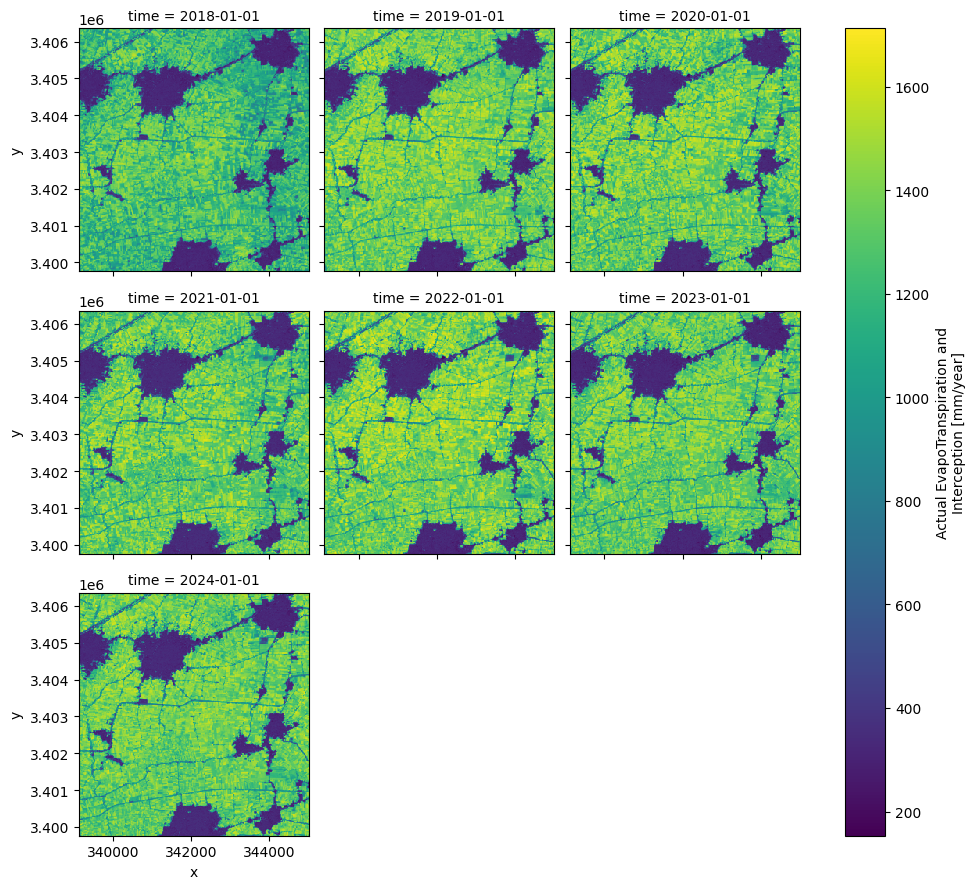

In [11]:
aeti_xr[variable].plot(col='time', col_wrap=3)

## Load dekadal biomass

The cell below loads dekadal actual evapotranspiration using the same procedure as for annual. The only parameter changed is `variable`.

In [12]:
variable = 'L3-NPP-D'
period = ["2024-01-01", "2024-03-01"]

npp_d = wapor_map(region, variable, period, folder, extension = '.nc')

npp_d_xr = load_wapor_ds(filename=npp_d, variable=variable)

npp_d_xr

INFO: Found 7 files for L3-NPP-D.
INFO: Converting from `.tif` to `.nc`.


<xarray.Dataset> Size: 5MB
Dimensions:      (x: 294, y: 330, time: 7)
Coordinates:
  * x            (x) float64 2kB 3.391e+05 3.392e+05 ... 3.45e+05 3.45e+05
  * y            (y) float64 3kB 3.406e+06 3.406e+06 ... 3.4e+06 3.4e+06
    spatial_ref  int32 4B 32636
  * time         (time) datetime64[ns] 56B 2024-01-01 2024-01-11 ... 2024-03-01
Data variables:
    L3-NPP-D     (time, y, x) float64 5MB 5.136 5.059 4.966 ... 7.505 7.186
Attributes:
    long_name:            Net Primary Production
    overview:             NONE
    temporal_resolution:  Dekad
    units:                gC/m²/day
    scale_factor:         0.001
    _FillValue:           -9999
    add_offset:           0.0

### Plot dekadal net primary productivity

It's interesting to note that in the Egypt example, some areas show very high biomass production > 30t/ha, especially in 2023. This must be considered in the context of several crop cycles occurring within a 12 month period.

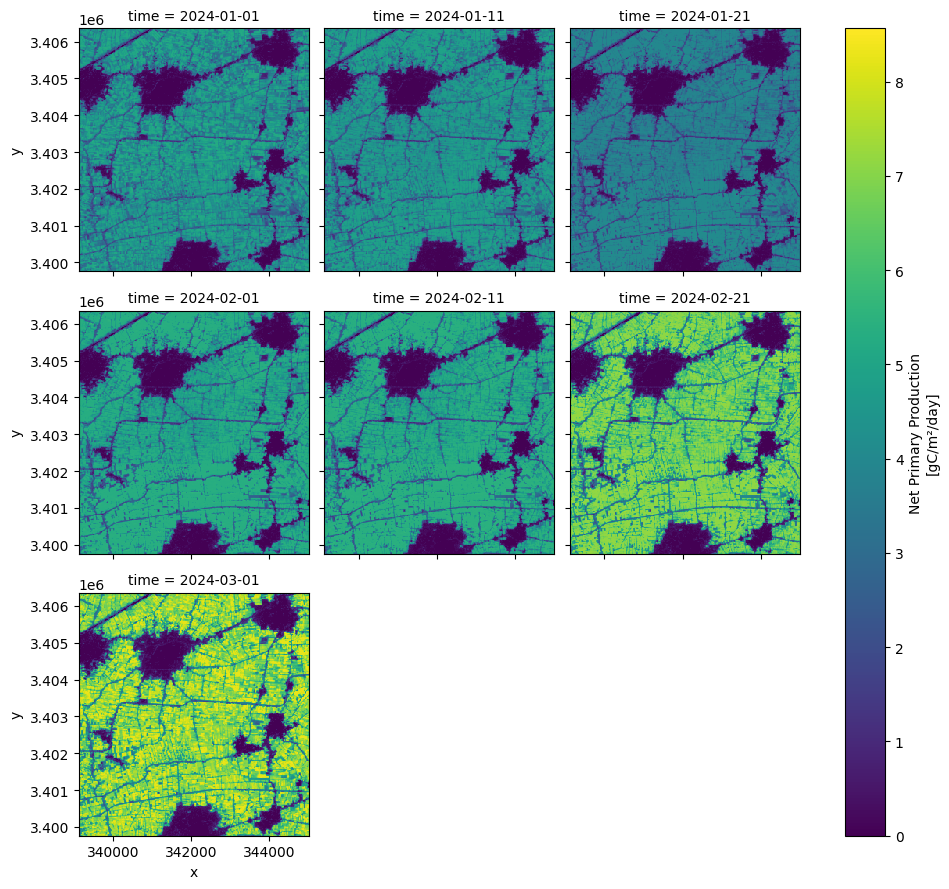

In [13]:
npp_d_xr[variable].plot(col='time', col_wrap=3)

## Conclusion

This notebook demonstrated the range of WaPOR variables available and how to load them in the DE Africa Sandbox environment. Subsequent notebooks will dive deeper into analysing WaPOR data alongside DE Africa data.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [15]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-02-17'